<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
Meep Tutorial: Transmittance Spectrum of a Waveguide Bend
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>January, 2025</font></center>

***

We have computed the field patterns for light propagating around a waveguide bend. While this can be visually informative, the results are not quantitatively satisfying. We'd like to know exactly how much power makes it around the bend (transmittance), how much is reflected (reflectance), and how much is radiated away (scattered loss). How can we do this?

The computation involves keeping track of the fields and their Fourier transform in a certain region, and from this computing the flux of electromagnetic energy as a function of $\omega$. Moreover, we'll get an entire spectrum of the transmittance in a single run, by Fourier-transforming the response to a short pulse. However, in order to normalize the transmitted flux by the incident power to obtain the transmittance, we'll have to do two runs, one with and one without the bend (i.e., a straight waveguide).

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format='svg'


In [2]:
resolution = 10  # pixels/um

sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx, sy, 0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

We'll also define a couple of parameters to set the width of the waveguide and the "padding" between it and the edge of the cell:

In [3]:
pad = 4  # padding distance between waveguide and cell edge
w = 1  # width of waveguide

In order to define the waveguide positions, we will have to use arithmetic to define the horizontal and vertical waveguide centers as:

In [4]:
wvg_xcen = 0.5 * (sx - w - 2 * pad)  # x center of horiz. wvg
wvg_ycen = -0.5 * (sy - w - 2 * pad)  # y center of vert. wvg

We proceed to define the geometry. We have to do two simulations with different geometries: the bend, and also a straight waveguide for normalization. We will first set up the straight waveguide.

In [5]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, w, mp.inf),
        center=mp.Vector3(0, wvg_ycen, 0),
        material=mp.Medium(epsilon=12),
    )
]

In [6]:
fcen = 0.15  # pulse center frequency
df = 0.1  # pulse width (in frequency)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-0.5 * sx + dpml, wvg_ycen, 0),
        size=mp.Vector3(0, w, 0),
    )
]

In [7]:
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-0.5 * sx + dpml + 0.5, wvg_ycen, 0), size=mp.Vector3(0, 2 * w, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml, wvg_ycen, 0), size=mp.Vector3(0, 2 * w, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)


     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


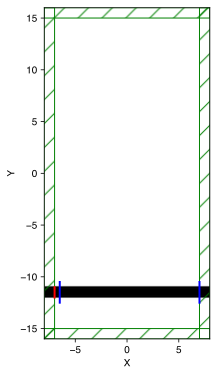

In [8]:
plt.figure(figsize=(8, 6))
sim.plot2D()
plt.show()

In [9]:
pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 6.69956e-05 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0247428 s
-----------
field decay(t = 50.050000000000004): 4.8251893805577916e-09 / 4.8251893805577916e-09 = 1.0
field decay(t = 100.05000000000001): 0.02880180987942583 / 0.02880180987942583 = 1.0
field decay(t = 150.1): 0.026893465093385728 / 0.02880180987942583 = 0.9337421921042781
field decay(t = 200.15): 2.315839732901194e-13 / 0.02880180987942583 = 8.040604887665347e-12
run 0 finished at t = 200.15 (4003 timesteps)


In [10]:
straight_tran_flux = mp.get_fluxes(tran)

In [11]:
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(sx - pad, w, mp.inf),
        center=mp.Vector3(-0.5 * pad, wvg_ycen),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(w, sy - pad, mp.inf),
        center=mp.Vector3(wvg_xcen, 0.5 * pad),
        material=mp.Medium(epsilon=12),
    ),
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5, 0), size=mp.Vector3(2 * w, 0, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 7.70092e-05 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0256729 s
-----------
field decay(t = 50.050000000000004): 1.6976522694449012e-10 / 1.6976522694449012e-10 = 1.0
field decay(t = 100.05000000000001): 4.691071063910556e-07 / 4.691071063910556e-07 = 1.0
field decay(t = 150.1): 2.992872733686181e-07 / 4.691071063910556e-07 = 0.6379934758846462
field decay(t = 200.15): 0.00392781356527228 / 0.00392781356527228 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939073855 / 0.00392781356527228 = 0.03821230740627938
field decay(t = 300

     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


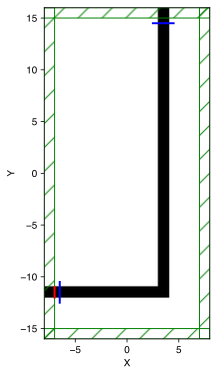

In [12]:
plt.figure(figsize=(8, 6))
sim.plot2D()
plt.show()

In [20]:
wl = 1. / np.array(flux_freqs)
Rs = - np.array(bend_refl_flux) / np.array(straight_tran_flux)
Ts = np.array(bend_tran_flux) / np.array(straight_tran_flux)

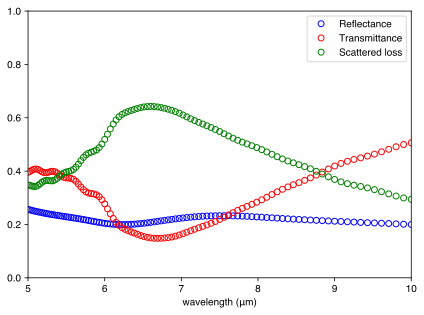

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.plot(wl, Rs, "bo", markerfacecolor='none', label="Reflectance")
ax.plot(wl, Ts, "ro", markerfacecolor='none', label="Transmittance")
ax.plot(wl, 1 - Rs - Ts, "go", markerfacecolor='none', label="Scattered loss")
ax.axis([5.0, 10.0, 0, 1])
ax.set_xlabel("wavelength (μm)")
ax.legend(loc=1)

fig.tight_layout()
plt.show()